# **Bước thu thập dữ liệu**

<h3> Ở bước này thì sẽ làm sạch data. Để làm được điều này nhóm đã thự hiện các bước làm sạch sau

In [31]:
!pip install pandas numpy underthesea gensim

<h3> IMPORT THƯ VIỆN

In [32]:
import pandas as pd
import numpy as np
import re
import string
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# Thư viện xử lý tiếng Việt
from underthesea import word_tokenize, sent_tokenize

# Thư viện tạo bigram/trigram
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [33]:
STOPWORDS_PATH = r"C:\Users\ADMIN\python\NLP-final\vietnamese-stopwords-dash.txt"
ACRONYMS_PATH = r"C:\Users\ADMIN\python\NLP-final\viet_tat_clean.txt"
INPUT_CSV = r"C:\Users\ADMIN\python\NLP-final\news_DB.csv"
OUTPUT_CSV = r"C:\Users\ADMIN\python\NLP-final\final_data.csv"

<h3> LOAD STOPWORDS VÀ TỪ VIẾT TẮT VÀ SỐ DÒNG HIỆN CÓ

In [34]:
print(len(pd.read_csv(INPUT_CSV)))
# Load stopwords từ file
with open(STOPWORDS_PATH, 'r', encoding='utf-8') as f:
    stopwords = set([line.strip().lower() for line in f if line.strip()])

print(f"✓ Đã load {len(stopwords)} stopwords")
print(f"  Ví dụ: {list(stopwords)[:10]}")

# Load từ viết tắt từ file
acronyms_df = pd.read_csv(ACRONYMS_PATH)
acronyms_dict = dict(zip(acronyms_df['acronym_words'], 
                          acronyms_df['fullform']))

print(f"\n✓ Đã load {len(acronyms_dict)} từ viết tắt")
print(f"  Ví dụ: {list(acronyms_dict.items())[:5]}")

3450
✓ Đã load 1957 stopwords
  Ví dụ: ['tránh_khỏi', 'cái_họ', 'chơi', 'gặp_khó_khăn', 'đâu_đây', 'thốt_thôi', 'bức', 'mạnh', 'chành_chạnh', 'căn_cắt']

✓ Đã load 196 từ viết tắt
  Ví dụ: [('vđv', 'vận động viên'), ('ubnd', 'ủy ban nhân dân'), ('sgc', 'sở giao dịch'), ('sra', 'sân bay'), ('vs', 'với')]


<h4> LOAD DỮ LIỆU GỐC

In [35]:
print("\n Đang load dữ liệu...")
df = pd.read_csv(INPUT_CSV)

print(f"✓ Đã load {len(df)} dòng")
print(f"✓ Cột: {list(df.columns)}")
print(f"\n Thông tin dữ liệu:")
print(df.info())
print(f"\n 5 dòng đầu tiên:")
df.head()


 Đang load dữ liệu...
✓ Đã load 3450 dòng
✓ Cột: ['title', 'description', 'time', 'category']

 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450 entries, 0 to 3449
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        3450 non-null   object
 1   description  3450 non-null   object
 2   time         3450 non-null   object
 3   category     3450 non-null   object
dtypes: object(4)
memory usage: 107.9+ KB
None

 5 dòng đầu tiên:


,title,description,time,category
0,Tin mới,Tin thời sự nóng mới nhất 24h hôm nay về đời s...,"Mon, 08 Dec 2025 16:30:59 GMT",Tin mới
1,Tin Video,"Video hot, clip nóng trong tuần chủ đề thời sự...","Mon, 08 Dec 2025 16:31:02 GMT",Tin mới
2,"Bóng đá hôm nay, tin bóng đá, chuyển nhượng mớ...",Trung vệ người Brazil bị rách cơ nhị đầu đùi t...,"Mon, 08 Dec 2025 16:31:04 GMT",Bóng đá
3,Tiện ích,"Thời tiết, tỷ giá ngoại tệ, giá vàng, kết quả ...","Mon, 08 Dec 2025 16:31:05 GMT",Tin mới
4,Xổ số hôm nay,"Kết quả xổ số hôm nay, 8-12, của xổ số miền Na...","Mon, 08 Dec 2025 16:31:07 GMT",Tin mới


<h1> Tiến hành Lọc Dữ liệu theo từng bước 

<h2> BƯỚC 1 - LỌC VÀ LOẠI BỎ NULL

In [36]:
df_original_len = len(df)

In [37]:
# Loại bỏ dòng null ở cột title và description
df = df.dropna(subset=['title', 'description'])

# Loại bỏ dòng trống
df = df[df['title'].str.strip() != '']
df = df[df['description'].str.strip() != '']

print(f"✓ Đã loại bỏ {df_original_len - len(df)} dòng NULL")
print(f"Còn lại: {len(df)} dòng")

✓ Đã loại bỏ 0 dòng NULL
Còn lại: 3450 dòng


In [38]:
print("\n[BƯỚC 2] Loại bỏ dòng < 50 từ...")

def count_words(text):
    """Đếm số từ trong văn bản"""
    return len(str(text).split())

# Tính tổng số từ trong title + description
df['total_words'] = df['title'].apply(count_words) + df['description'].apply(count_words)

df_before_filter = len(df)
df = df[df['total_words'] >= 50]

print(f"✓ Đã loại bỏ {df_before_filter - len(df)} dòng < 50 từ")
print(f"Còn lại: {len(df)} dòng")

# Xóa cột tạm
df = df.drop('total_words', axis=1)


[BƯỚC 2] Loại bỏ dòng < 50 từ...
✓ Đã loại bỏ 978 dòng < 50 từ
Còn lại: 2472 dòng


<H4> LOẠI BỎ CỘT TIME 

In [39]:
print("\n[BƯỚC 3] Loại bỏ cột time...")
if 'time' in df.columns:
    df = df.drop('time', axis=1)
    print("✓ Đã loại bỏ cột 'time'")
print(f"Các cột còn lại: {list(df.columns)}")


[BƯỚC 3] Loại bỏ cột time...
✓ Đã loại bỏ cột 'time'
Các cột còn lại: ['title', 'description', 'category']


In [40]:
df['description'] = df['title'].astype(str) + '. ' + df['description'].astype(str)

# Xóa cột title vì đã gộp rồi
df = df.drop('title', axis=1)

In [41]:
df.head()

,description,category
2,"Bóng đá hôm nay, tin bóng đá, chuyển nhượng mớ...",Bóng đá
4,"Xổ số hôm nay. Kết quả xổ số hôm nay, 8-12, củ...",Tin mới
5,Giá vàng hôm nay. Tổng Bí thư dự Lễ kỷ niệm 80...,Tin mới
6,"Thời tiết hôm nay, ngày mai và 7 ngày tới. Dự ...",Tin mới
7,"Lịch âm hôm nay, xem lịch vạn niên 2025, lịch ...",Tin mới


<h2> BƯỚC 2 - CHUẨN HÓA VĂN BẢN

<H4> CHUYỂN VỀ DẠNG CHỮ THƯỜNG 

In [42]:
# Chuyển sang lowercase
df['description'] = df['description'].str.lower()


<H4> THAY THẾ CHỮ VIẾT TẮT THÀNH BẢNG ĐẦY ĐỦ THÔNG QUA FILE viet_tat_clean


In [43]:
def expand_acronyms(text, acronym_dict):
    """
    Thay thế các từ viết tắt thành dạng đầy đủ
    """
    words = text.split()
    expanded_words = []
    
    for word in words:
        # Loại bỏ dấu câu ở đầu cuối từ để kiểm tra
        word_clean = word.strip(string.punctuation)
        
        if word_clean in acronym_dict:
            expanded_words.append(acronym_dict[word_clean])
        else:
            expanded_words.append(word)
    
    return ' '.join(expanded_words)

In [44]:
# Áp dụng cho description
print("Đang xử lý description...")
df['description'] = df['description'].apply(lambda x: expand_acronyms(x, acronyms_dict))

Đang xử lý description...


<h2> BƯỚC 3 - LÀM SẠCH VĂN BẢN

<h4> Xoá sạch mọi ký tự đặc biệt, dấu câu, khoảng trắng thừa, url,...

In [45]:
def clean_text_thoroughly(text):
    if not isinstance(text, str):
        return ""
     # 1. Loại bỏ emoji (sử dụng regex pattern mở rộng)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # 2. Loại bỏ URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Loại bỏ email
    text = re.sub(r'\S+@\S+', '', text)
    
    # 4. Xoá hết số
    text = re.sub(r'\d+', '', text)

    # 5. GIỮ tiếng Việt – loại bỏ mọi dấu câu & ký tự đặc biệt khác
    text = re.sub(r"[^a-zA-ZÀ-ỹĂăÂâÊêÔôƠơÚúƯư\s_-]", " ", text)
       
    # 6. Loại bỏ dấu gạch thừa
    text = re.sub(r'_+', '_', text)
    text = re.sub(r'-+', '-', text)
    text = re.sub(r'\s[-_]+\s', ' ', text)
    text = re.sub(r'^[-_]+|[-_]+$', '', text)
    
    # 7. Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
    

In [46]:
print("Đang làm sạch description...")
df['description'] = df['description'].apply(clean_text_thoroughly)

# Loại bỏ các dòng trở thành rỗng sau khi clean
df = df[(df['description'].str.len() > 0)]

print(f"✓ Đã làm sạch văn bản triệt để ")
print(f"Còn lại: {len(df)} dòng sau khi làm sạch")

Đang làm sạch description...
✓ Đã làm sạch văn bản triệt để 
Còn lại: 2472 dòng sau khi làm sạch


<h2> BƯỚC 5 - TOKENIZATION TIẾNG VIỆT (sử dụng underthesea để tạo ra các cụm cho bộ xử lý Tiếng Việt)

In [47]:
def tokenize_vietnamese_sent(text):
    """
    Tách câu → tách từ cho tiếng Việt
    """
    try:
        # Tách câu trước
        sentences = sent_tokenize(text)
        # Tách từ cho mỗi câu
        tokenized_sents = [word_tokenize(sent, format="text") for sent in sentences]
        # Ghép lại
        return ' '.join(tokenized_sents)
    except:
        return text

In [48]:
print("Đang tokenize description...")
tqdm.pandas(desc="Tokenizing")
df['description'] = df['description'].progress_apply(tokenize_vietnamese_sent)

print("✓ Đã hoàn thành tokenization cho description")
print(f"\nVí dụ description sau tokenization:")
print(df['description'].iloc[0][:200] + "...")

Đang tokenize description...


Tokenizing: 100%|██████████| 2472/2472 [01:07<00:00, 36.60it/s] 

✓ Đã hoàn thành tokenization cho description

Ví dụ description sau tokenization:
bóng_đá hôm_nay tin bóng_đá chuyển_nhượng mới nhất_h trung_vệ người brazil bị rách cơ_nhị đầu đùi trái kèm tổn_thương gân buộc phải nghỉ thi_đấu đến tháng đây là cú giáng mạnh vào hàng thủ_real vốn bị...


In [49]:
print("\n Hoàn thành tokenization")
print(" Underthesea đã tách từ tiếng Việt")
print("\n Ví dụ sau tokenization:")
print(f"Description: {df['description'].iloc[0][:150]}...")


 Hoàn thành tokenization
 Underthesea đã tách từ tiếng Việt

 Ví dụ sau tokenization:
Description: bóng_đá hôm_nay tin bóng_đá chuyển_nhượng mới nhất_h trung_vệ người brazil bị rách cơ_nhị đầu đùi trái kèm tổn_thương gân buộc phải nghỉ thi_đấu đến t...


<h2> BƯỚC 6 - LOẠI BỎ STOPWORDS

In [50]:
# Các từ chung chung cần bỏ thêm vào stopwords
additional_stopwords = {
    # Từ chỉ phương hướng/vị trí quá chung
    'miền', 'bắc', 'nam', 'đông', 'tây', 'trung', 'ngoài',
    
    # Từ đơn lẻ bị tách từ từ ghép
    'ủy', 'hồ', 'hàng', 'đầu', 'xã', 'phường', 'bảng',
    
    # Đơn vị tiền tệ
    'triệu', 'tỷ', 'nghìn', 'đồng', 'usd', 'vnd',
    
    # Từ quá chung
    'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín', 'mười',
    'đi', 'lại', 'lên', 'xuống', 'vào', 'ra', 'tới', 'đến',
    'xe', 'đường', 'nhà', 'cửa', 
    
    # Từ hành chính chung chung
    'tỉnh', 'thành', 'huyện', 'xã', 'phường', 'thị_trấn',
    
    # Từ thời gian chung
    'ngày', 'tháng', 'năm', 'tuần', 'giờ', 'phút',
}

print(f"📝 Cần bổ sung thêm {len(additional_stopwords)} từ vào stopwords")
print(f"Danh sách: {sorted(additional_stopwords)}")


📝 Cần bổ sung thêm 50 từ vào stopwords
Danh sách: ['ba', 'bảng', 'bảy', 'bắc', 'bốn', 'chín', 'cửa', 'giờ', 'hai', 'huyện', 'hàng', 'hồ', 'lên', 'lại', 'miền', 'mười', 'nam', 'nghìn', 'ngoài', 'ngày', 'nhà', 'năm', 'phút', 'phường', 'ra', 'sáu', 'thành', 'tháng', 'thị_trấn', 'triệu', 'trung', 'tuần', 'tám', 'tây', 'tỉnh', 'tới', 'tỷ', 'usd', 'vnd', 'vào', 'xe', 'xuống', 'xã', 'đi', 'đông', 'đường', 'đầu', 'đến', 'đồng', 'ủy']


In [51]:
stopwords_extended = stopwords.union(additional_stopwords)

print(f"✓ Stopwords gốc: {len(stopwords)}")
print(f"✓ Stopwords mở rộng: {len(stopwords_extended)}")
print(f"✓ Đã thêm: {len(additional_stopwords)} từ mới")

✓ Stopwords gốc: 1957
✓ Stopwords mở rộng: 1992
✓ Đã thêm: 50 từ mới


<h4> HÀM LOẠI BỎ STOPWORDS CƠ BẢN

In [52]:
def remove_stopwords(text, stopwords_set):
    """
    Loại bỏ các từ dừng (stopwords)
    """
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_set]
    return ' '.join(filtered_words)

In [53]:
def clean_stopwords_and_meaningless(text, stopwords_set):
    """
    Xóa stopwords
    """
    text = remove_stopwords(text, stopwords_set)
    
    return text

In [54]:
print("Đang loại bỏ stopwords từ description...")
df['description'] = df['description'].apply(lambda x: remove_stopwords(x, stopwords_extended))


Đang loại bỏ stopwords từ description...


In [55]:
print("\n Ví dụ sau khi xóa stopwords:")
print(f"Description: {df['description'].iloc[0][:200]}...")


 Ví dụ sau khi xóa stopwords:
Description: bóng_đá bóng_đá chuyển_nhượng nhất_h trung_vệ brazil rách cơ_nhị đùi trái kèm tổn_thương gân buộc nghỉ thi_đấu cú giáng thủ_real vốn tàn_phá chấn_thương neymar buộc bàn mổ đối_diện nguy_cơ vắng_mặt wo...


In [56]:
def remove_invalid_words(text, min_len=1, max_len=30):
    """
    Loại bỏ:
    - Từ quá ngắn (< 2 ký tự)
    - Từ quá dài bất thường (> 30 ký tự - có thể là lỗi)
    - Từ chỉ chứa ký tự lặp lại (aaaa, !!!!!, -----)
    """
    words = text.split()
    valid_words = []
    
    for word in words:
        
        if not (min_len <= len(word) <= max_len):
            continue  # Bỏ từ quá ngắn hoặc quá dài
        
        if len(set(word)) == 1:
            continue  # Bỏ từ chỉ có ký tự lặp lại
        
        valid_words.append(word)
    return ' '.join(valid_words)

In [57]:
print("Đang loại bỏ từ không hợp lệ từ description...")
df['description'] = df['description'].apply(remove_invalid_words)

Đang loại bỏ từ không hợp lệ từ description...


In [58]:
# Xóa dấu _ thừa nếu còn sót
df['description'] = df['description'].apply(lambda x: re.sub(r'_{2,}', '_', x))
df['description'] = df['description'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

<h3> Lọc lại 1 lần nữa nếu decription dưới 10 từ sẽ xoá đi

In [59]:
df['word_count'] = df['description'].apply(count_words)
before_final = len(df)

# Giữ lại dòng có ít nhất 20 từ trong description
df = df[df['word_count'] >= 20]
df = df.drop('word_count', axis=1)

print(f"Loại bỏ {before_final - len(df)} dòng quá ngắn sau xử lý")
print(f"Còn lại: {len(df)} dòng cuối cùng")



Loại bỏ 83 dòng quá ngắn sau xử lý
Còn lại: 2389 dòng cuối cùng


<h2> BƯỚC 9 - XUẤT FILE KẾT QUẢ

In [60]:
# Chỉ giữ lại 3 cột: title, description, category
final_df = df[['description', 'category']].copy()

# Reset index
final_df = final_df.reset_index(drop=True)

# Lưu file
final_df.to_csv('final_data.csv', index=False, encoding='utf-8-sig')


print(f"Đã xuất file 'final_data.csv'")
print(f"   - Số dòng: {len(final_df)}")
print(f"   - Các cột: {list(final_df.columns)}")

Đã xuất file 'final_data.csv'
   - Số dòng: 2389
   - Các cột: ['description', 'category']


<h2> XEM KẾT QUẢ CUỐI CÙNG

In [62]:
print(f"\nDữ liệu ban đầu: {df_original_len} dòng")
print(f"Dữ liệu cuối cùng: {len(final_df)} dòng")
print(f"Tỷ lệ giữ lại: {len(final_df)/df_original_len*100:.2f}%")

print(f"\nPhân bố theo category:")
print(final_df['category'].value_counts())

print(f"\nThống kê độ dài văn bản:")
final_df['text_length'] =  final_df['description']
final_df['text_length'] = final_df['text_length'].apply(count_words)
print(f"  - Trung bình: {final_df['text_length'].mean():.2f} từ")
print(f"  - Trung vị: {final_df['text_length'].median():.2f} từ")
print(f"  - Min: {final_df['text_length'].min()} từ")
print(f"  - Max: {final_df['text_length'].max()} từ")

print("\n" + "="*80)
print("HOÀN THÀNH QUY TRÌNH TIỀN XỬ LÝ DỮ LIỆU!")
print("="*80)


Dữ liệu ban đầu: 3450 dòng
Dữ liệu cuối cùng: 2389 dòng
Tỷ lệ giữ lại: 69.25%

Phân bố theo category:
category
Tin mới         1657
Xe               249
Thế giới          86
Pháp luật         80
Thời sự           72
Giải trí          59
Thể thao          51
Kinh doanh        35
Xã hội            24
Bóng đá           16
Giáo dục          13
Sức khỏe          10
Công nghệ          8
Chính trị          6
Văn hóa            5
Du lịch            5
Đời sống           4
Bất động sản       4
Số hóa             3
Khoa học           2
Name: count, dtype: int64

Thống kê độ dài văn bản:
  - Trung bình: 215.17 từ
  - Trung vị: 221.00 từ
  - Min: 20 từ
  - Max: 519 từ

HOÀN THÀNH QUY TRÌNH TIỀN XỬ LÝ DỮ LIỆU!


In [63]:
# Hiển thị một vài mẫu kết quả
print("\nMẫu dữ liệu sau xử lý:")
print("-" * 80)
for i in range(min(3, len(final_df))):
    print(f"\n[Mẫu {i+1}]")
    print(f"Category: {final_df.iloc[i]['category']}")
    print(f"Description: {final_df.iloc[i]['description'][:200]}...")
    print("-" * 80)


Mẫu dữ liệu sau xử lý:
--------------------------------------------------------------------------------

[Mẫu 1]
Category: Bóng đá
Description: bóng_đá bóng_đá chuyển_nhượng nhất_h trung_vệ brazil rách cơ_nhị đùi trái kèm tổn_thương gân buộc nghỉ thi_đấu cú giáng thủ_real vốn tàn_phá chấn_thương neymar buộc bàn mổ đối_diện nguy_cơ vắng_mặt wo...
--------------------------------------------------------------------------------

[Mẫu 2]
Category: Tin mới
Description: công_ty kiến_thiết thành_phố chí_minh đồng_tháp cà_mau công_bố công_ty kiến_thiết hà_nội_phú yên_huế công_bố chí_minh thành_phố chí_minh thành_phố chí_minh chí_minh dự_đoán trung_online vietlott vietl...
--------------------------------------------------------------------------------

[Mẫu 3]
Category: Tin mới
Description: giá vàng tổng_bí_thư dự lễ kỷ_niệm truyền_thống quân_khu việt_nam-campuchia khai_trương cặp cửa_khẩu quốc_tế tham_mưu nhân_sự bảo_đảm tổ_chức thành_công đại_hội xiv việt_nam kêu_gọi campuchia thái_lan...
-

Phân Tích EDA

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

--- 1. Phân bố Dữ liệu theo Category ---


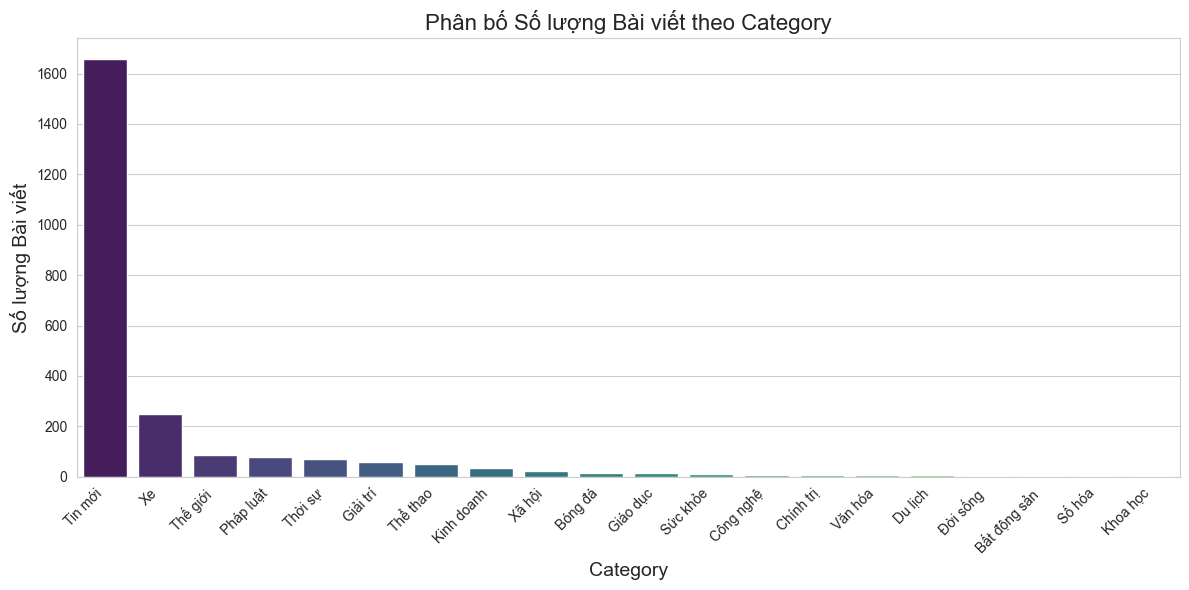

In [65]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)

# --- BƯỚC 1: PHÂN BỐ THEO CATEGORY ---
print("--- 1. Phân bố Dữ liệu theo Category ---")
plt.figure(figsize=(12, 6))
category_counts = final_df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Phân bố Số lượng Bài viết theo Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Số lượng Bài viết', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- 2. Top 30 Từ/Cụm từ Phổ biến Nhất ---


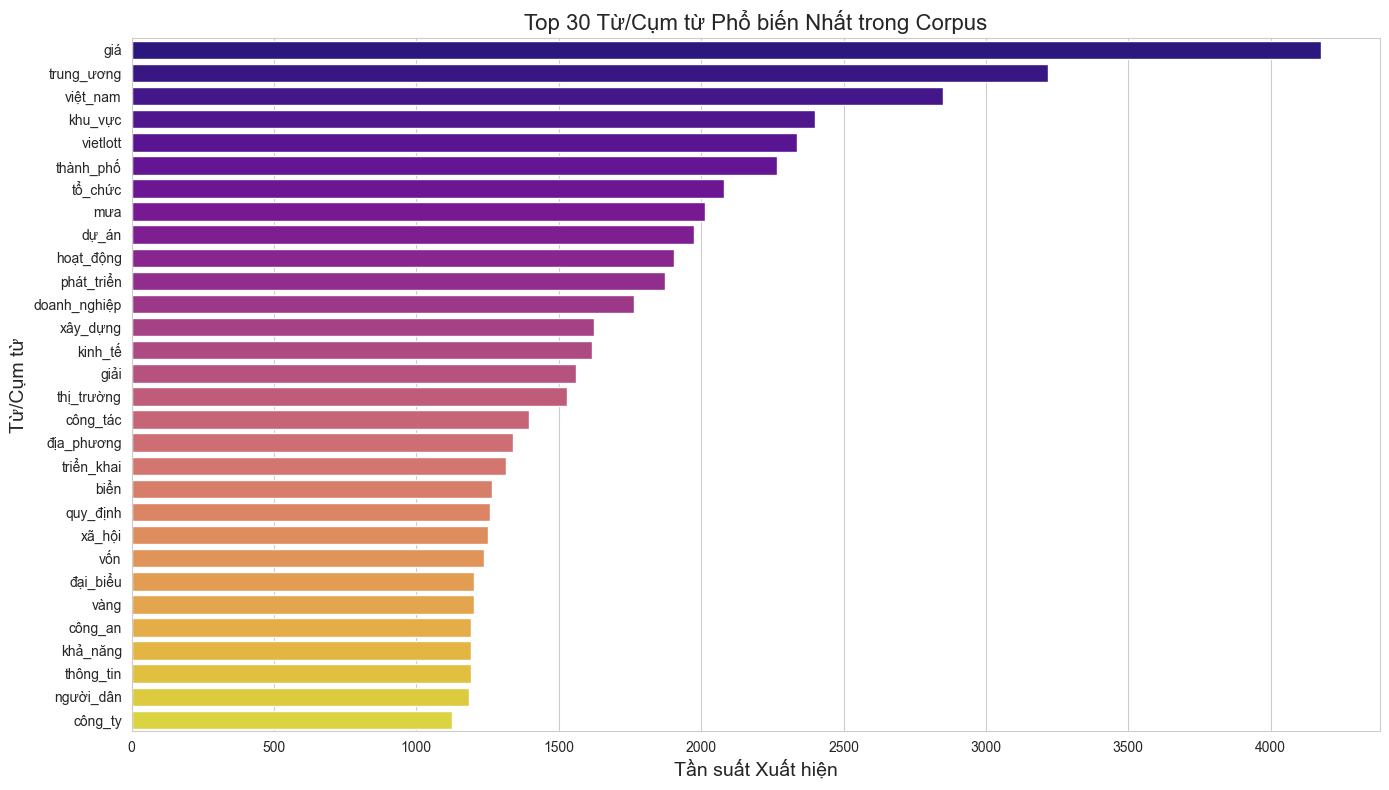

Ví dụ Top 5 từ: [('giá', 4175), ('trung_ương', 3219), ('việt_nam', 2851), ('khu_vực', 2400), ('vietlott', 2336)]
Tổng số từ vựng duy nhất: 20,666


In [67]:
print("\n--- 2. Top 30 Từ/Cụm từ Phổ biến Nhất ---")
all_tokens = []
# Lấy tất cả các token từ description đã xử lý
for text in final_df['description'].tolist():
    all_tokens.extend(text.split())

# Đếm tần suất
token_counts = Counter(all_tokens)

# Lấy 30 token phổ biến nhất
top_n = 30
most_common_tokens = token_counts.most_common(top_n)

# Trực quan hóa
tokens, counts = zip(*most_common_tokens)

plt.figure(figsize=(14, 8))
sns.barplot(x=list(counts), y=list(tokens), palette="plasma")
plt.title(f'Top {top_n} Từ/Cụm từ Phổ biến Nhất trong Corpus', fontsize=16)
plt.xlabel('Tần suất Xuất hiện', fontsize=14)
plt.ylabel('Từ/Cụm từ', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Ví dụ Top 5 từ: {most_common_tokens[:5]}")
print(f"Tổng số từ vựng duy nhất: {len(token_counts):,}")


--- 3. Phân bố Độ dài Văn bản (Tính bằng Token) ---


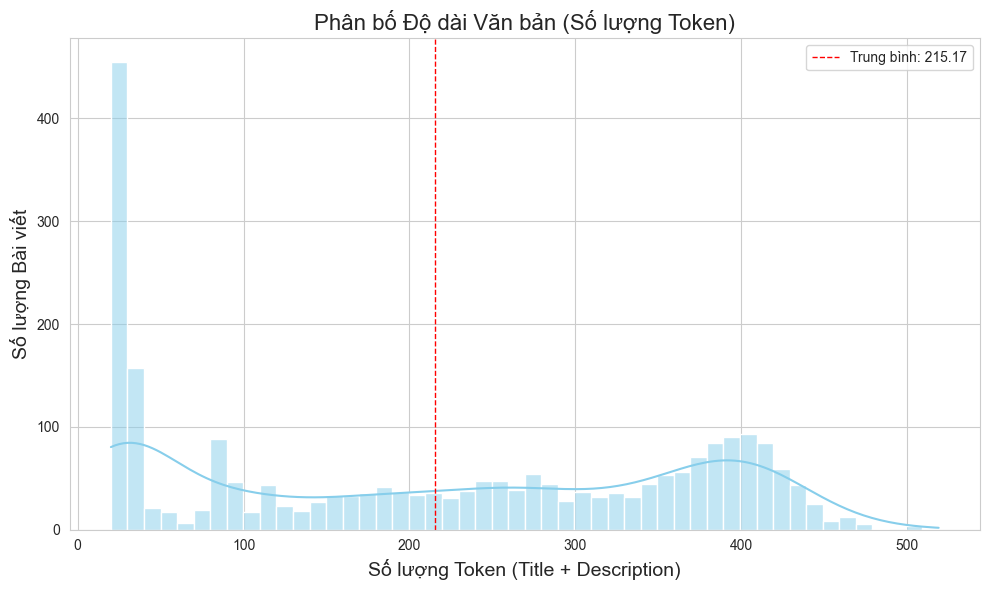

Thống kê độ dài:
count    2389.000000
mean      215.170364
std       150.569101
min        20.000000
25%        37.000000
50%       221.000000
75%       367.000000
max       519.000000
Name: text_length, dtype: float64


In [69]:
print("\n--- 3. Phân bố Độ dài Văn bản (Tính bằng Token) ---")
final_df['text_length'] = (final_df['description']).apply(
    lambda x: len(x.split())
)

plt.figure(figsize=(10, 6))
sns.histplot(final_df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Phân bố Độ dài Văn bản (Số lượng Token)', fontsize=16)
plt.xlabel('Số lượng Token (Title + Description)', fontsize=14)
plt.ylabel('Số lượng Bài viết', fontsize=14)
plt.axvline(final_df['text_length'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Trung bình: {final_df['text_length'].mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Thống kê độ dài:\n{final_df['text_length'].describe()}")

In [ ]:
# Kiểm tra các từ xuất hiện nhiều nhất
from collections import Counter

all_words = ' '.join(final_df['description']).split()
word_freq = Counter(all_words)

print("Top 50 từ xuất hiện nhiều nhất:")
print(word_freq.most_common(50))

Top 50 từ xuất hiện nhiều nhất:
[('giá', 3877), ('trung_ương', 3156), ('việt_nam', 2720), ('khu_vực', 2372), ('vietlott', 2287), ('thành_phố', 2194), ('tổ_chức', 2044), ('mưa', 1974), ('dự_án', 1921), ('hoạt_động', 1885), ('phát_triển', 1814), ('doanh_nghiệp', 1722), ('kinh_tế', 1584), ('xây_dựng', 1580), ('giải', 1551), ('thị_trường', 1501), ('công_tác', 1355), ('địa_phương', 1329), ('triển_khai', 1285), ('quy_định', 1236), ('xã_hội', 1225), ('biển', 1220), ('vốn', 1206), ('khả_năng', 1184), ('thông_tin', 1174), ('đại_biểu', 1164), ('công_an', 1157), ('người_dân', 1149), ('vàng', 1135), ('công_ty', 1109), ('mua', 1097), ('nhiệt_độ', 1058), ('công_nghiệp', 1053), ('kỳ', 1052), ('ngân_hàng', 1052), ('quốc_gia', 1047), ('cập_nhật', 1015), ('ban', 1013), ('chính_sách', 990), ('hệ_thống', 979), ('tiền', 977), ('ban_nhân_dân', 977), ('chủ_nhật', 977), ('quốc_hội', 976), ('giúp', 965), ('cơ_quan', 962), ('huế', 949), ('rét', 944), ('lực_lượng', 916), ('dự_báo', 915)]
